<a href="https://colab.research.google.com/github/GuilhermeBaldo/Coursera_Capstone/blob/main/Segmenting_and_Clustering_Neighborhoods_in_Toronto_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np

!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium==0.5.0
import folium

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

Reading the table from the URL: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M into a pandas DataFrame

In [2]:
wiki_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M',header=0)[0]
wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Ignoring the rows without Borough data 

In [3]:
wiki_df['Borough'].value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
York                 5
East York            5
Mississauga          1
Name: Borough, dtype: int64

In [4]:
wiki_df = wiki_df[wiki_df['Borough'] != 'Not assigned']
wiki_df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Check if there are any neighbourhoods not assigned left


In [5]:
wiki_df[wiki_df['Neighbourhood'] == 'Not assigned']

,Postal Code,Borough,Neighbourhood


No data without neighbourhoods assigned were found

Combining data with same postal code


In [6]:
wiki_df = wiki_df.groupby('Postal Code', sort=False).agg(','.join).reset_index()
wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Wiki table shape

In [7]:
wiki_df.shape

(103, 3)

Getting the coordinates of the postal codes

In [8]:
lat_long_df = pd.read_csv('https://cocl.us/Geospatial_data')
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Filling the wiki dataframe with lat and long data

In [9]:
for i in wiki_df.index:
  df = lat_long_df[lat_long_df['Postal Code'] == wiki_df.loc[i, 'Postal Code']].reset_index()
  wiki_df.loc[i, 'Latitude'] = df.loc[0, 'Latitude']
  wiki_df.loc[i, 'Longitude'] = df.loc[0, 'Longitude']

wiki_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Working only with Borough that contains the word Toronto

In [10]:
wiki_df = wiki_df[wiki_df['Borough'].str.contains('Toronto')]
wiki_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


Create the map of the Boroughs

In [11]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(wiki_df['Latitude'], wiki_df['Longitude'], wiki_df['Borough'], wiki_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Defining foursquare api credentials

In [13]:
CLIENT_ID = 'UMFUO1S5L1WRF0L5WIEYAWXKI1NG2CGXRKLB2DDLKEYKV4RA'
CLIENT_SECRET = '3AFADASJFJ5PGGRWNTER0UEHZTI1NM01WO1DK5VOEHEZKO4B'
VERSION = '20180605'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UMFUO1S5L1WRF0L5WIEYAWXKI1NG2CGXRKLB2DDLKEYKV4RA
CLIENT_SECRET:3AFADASJFJ5PGGRWNTER0UEHZTI1NM01WO1DK5VOEHEZKO4B


Function that gest the nearby venues from a borough

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Getting the nearby venues from every borough from the wiki dataframe

In [15]:
toronto_venues = getNearbyVenues(names=wiki_df['Neighbourhood'],
                                   latitudes=wiki_df['Latitude'],
                                   longitudes=wiki_df['Longitude']
                                  )

toronto_venues.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Checking the size of the resulting venues dataframe

In [16]:
toronto_venues.shape

(1618, 7)

Checking the number of unique categories to be analyzed

In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


Creating dataframe with onehot encoding from categories

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,...,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Check the dataframe shape

In [19]:
toronto_onehot.shape

(1618, 236)

Grouping by neighbourhoods (the encoding is the mean of values for each neighbourhood and category)

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,...,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.016949,0.000000,0.0,0.0,0.0000,0.0,0.0,0.016949,0.033898,0.0,0.000000,0.0,0.016949,0.016949,0.0,0.033898,0.0,0.0,0.000000,0.016949,0.0,0.0000,0.0,0.0000,0.0,0.016949,0.0000,0.000000,0.0,0.000000,0.000000,...,0.033898,0.0,0.016949,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.016949,0.0,0.000000,0.0,0.016949,0.0,0.0,0.0,0.016949,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.045455,0.0,0.045455,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.0000,0.0,0.090909,0.0000,0.000000,0.0,0.000000,0.045455,...,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.045455,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0625,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.0000,0.0,0.000000,0.0625,0.000000,0.0,0.000000,0.062500,...,0.000000,0.0,0.000000,0.0625,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0625,0.0625,0.125,0.125,0.125,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.062500,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0625,0.0,0.0625,0.0,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,Central Bay Street,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,0.015873,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.015873,0.000000,0.0,0.0000,0.0,0.0000,0.0,0.000000,0.0000,0.031746,0.0,0.031746,0.000000,...,0.015873,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.015873,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.015873,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.031746,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.0,0.0,0.015873,0.0,0.015873


Check the dataframe shape

In [21]:
toronto_grouped.shape

(39, 236)

In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.08
1    Cocktail Bar  0.05
2          Bakery  0.03
3  Farmers Market  0.03
4        Beer Bar  0.03


----Brockton, Parkdale Village, Exhibition Place----
                venue  freq
0                Café  0.14
1      Breakfast Spot  0.09
2         Coffee Shop  0.09
3  Italian Restaurant  0.05
4             Stadium  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2       Garden Center  0.06
3          Comic Shop  0.06
4                Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4               Bar  0.06


----Central Bay Street----
                venue  freq
0         Coffee Sho

Creating a dataframe with the 10 most popular venues from each neighbourhood sorted

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Cheese Shop,Restaurant,Bakery,Seafood Restaurant,Farmers Market,Irish Pub,Butcher
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Grocery Store,Bakery,Performing Arts Venue,Pet Store,Nightclub,Climbing Gym,Restaurant
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Brewery,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Bar,Coffee Shop,Rental Car Location,Sculpture Garden,Boutique,Boat or Ferry
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Bubble Tea Shop,Salad Place,Burger Joint,Japanese Restaurant,Thai Restaurant,Comic Shop


Clustering the neighbourhoods using k-means

Checking the best k value using the elbow method

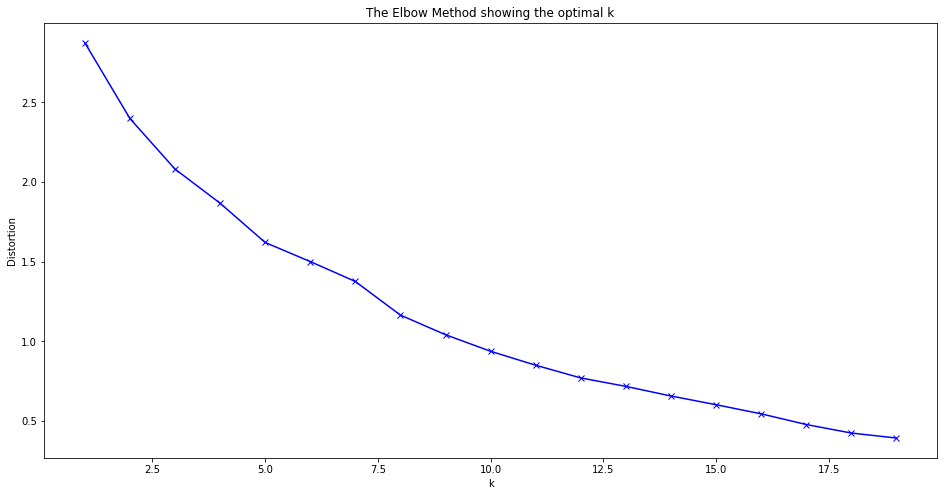

In [25]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

distortions = []
K = range(1,20)
for k in K:
  kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
  distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Clustering using k=8

In [26]:
kclusters = 8

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 6, 6, 6, 1, 4, 1, 1, 1, 1], dtype=int32)

Joining the clustering info to the wiki dataframe

In [27]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = wiki_df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Café,Theater,Breakfast Spot,Pub,Event Space,Italian Restaurant,Spa
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Beer Bar,Burger Joint,Sandwich Place,Burrito Place,Café,Portuguese Restaurant,Park
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Hotel,Bubble Tea Shop,Middle Eastern Restaurant,Japanese Restaurant,Diner,Bookstore
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Cosmetics Shop,Cheese Shop,Clothing Store,Moroccan Restaurant,Creperie
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Neighborhood,Pub,Health Food Store,Trail,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Eastern European Restaurant


Showing the clustered neighbourhoods in the maps

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters